In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import keras.utils as image
from keras.utils import Sequence
from keras.preprocessing.image import ImageDataGenerator


1. Data Preprocessin

In [ ]:
CSV_PATH = "../ground_truth.csv"
IMAGE_FOLDER = "../data/"

In [9]:
# Učitavanje CSV-a
df = pd.read_csv(CSV_PATH)

In [10]:
print("Prvih nekoliko redova iz CSV-a:")
print(df.head())

Prvih nekoliko redova iz CSV-a:
     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0  


In [11]:
print("Nedostajuće vrednosti u CSV-u:")
print(df.isnull().sum())

Nedostajuće vrednosti u CSV-u:
image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64


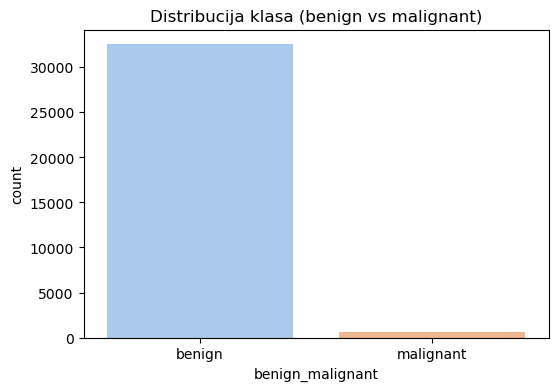

In [7]:
# Provera broja klasa (benign vs malignant)
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="benign_malignant", hue="benign_malignant", palette="pastel")
plt.title("Distribucija klasa (benign vs malignant)")
plt.show()

In [8]:
df['benign_malignant'].value_counts()

benign_malignant
benign       32542
malignant      584
Name: count, dtype: int64

In [9]:
# Prikaz nekoliko primera slika
def prikazi_slike(broj_slika=6):
    sample = df.sample(broj_slika)  # Nasumično biramo slike
    fig, axes = plt.subplots(1, broj_slika, figsize=(15, 5))

    for i, (idx, row) in enumerate(sample.iterrows()):
        img_path = os.path.join(IMAGE_FOLDER, row["image_name"] + ".jpg")
        if os.path.exists(img_path):  # Proveravamo da li slika postoji
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"{row['benign_malignant']}")
            axes[i].axis("off")
        else:
            axes[i].set_title("N/A")
            axes[i].axis("off")

    plt.show()

Resultt

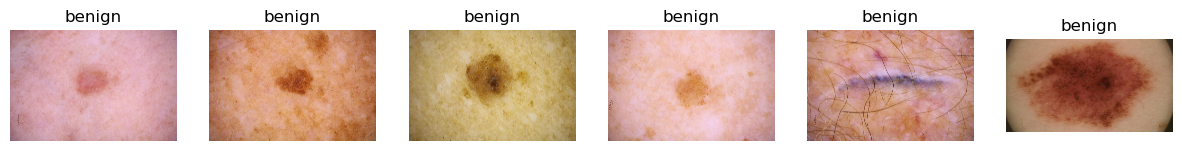

In [19]:
prikazi_slike()

Aster downsampling 

In [11]:
benign = df[df['target'] == 0].sample(3000, random_state=42)
malignant = df[df['target'] == 1]
new_data = pd.concat([benign, malignant]).reset_index(drop=True)

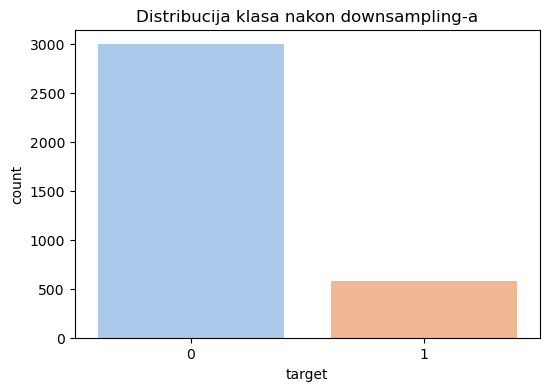

In [12]:
# Vizualizacija distribucije klasa
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=new_data, hue='target', palette='pastel', legend=False)
plt.title('Distribucija klasa nakon downsampling-a')
plt.show()


In [13]:
new_data['target'].value_counts()

target
0    3000
1     584
Name: count, dtype: int64

2. Creating the Dataset class


In [14]:
# Kreiranje klase Data
class Data(Sequence):
    def __init__(self, image_names, labels, batch_size, image_folder="data/", target_size=(224, 224), aug=None, shuffle=True):
        self.image_names = np.array(image_names)
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.image_folder = image_folder
        self.target_size = target_size
        self.aug = aug
        self.shuffle = shuffle
        self.indices = np.arange(len(self.image_names))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.image_names) / self.batch_size))  # Ceo broj batch-ova
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size: (index + 1) * self.batch_size]
        batch_images = [self.load_data(self.image_names[i]) for i in batch_indices]
        batch_labels = self.labels[batch_indices]
        
        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)
        
        # Popravljeno augmentiranje
        if self.aug:
            batch_images = self.aug.flow(batch_images, batch_size=self.batch_size, shuffle=False)[0]
        
        return batch_images, batch_labels
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def load_data(self, image_name):
        img_path = os.path.join(self.image_folder, image_name + ".jpg")
        if not os.path.exists(img_path):  # Ako slika ne postoji, vrati crnu sliku
            return np.zeros((*self.target_size, 3), dtype=np.float32)

        img = image.load_img(img_path, target_size=self.target_size)
        img = image.img_to_array(img) / 255.0
        return img

In [15]:
# Definicija augmentacije
datagen = ImageDataGenerator(
    rotation_range=30,  
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2,     
    zoom_range=0.2,  
    horizontal_flip=True,
    fill_mode='nearest'
)

In [16]:
# Kreiranje dataset objekta
dataset = Data(df['image_name'].values, df['target'].values, batch_size=32, aug=datagen)

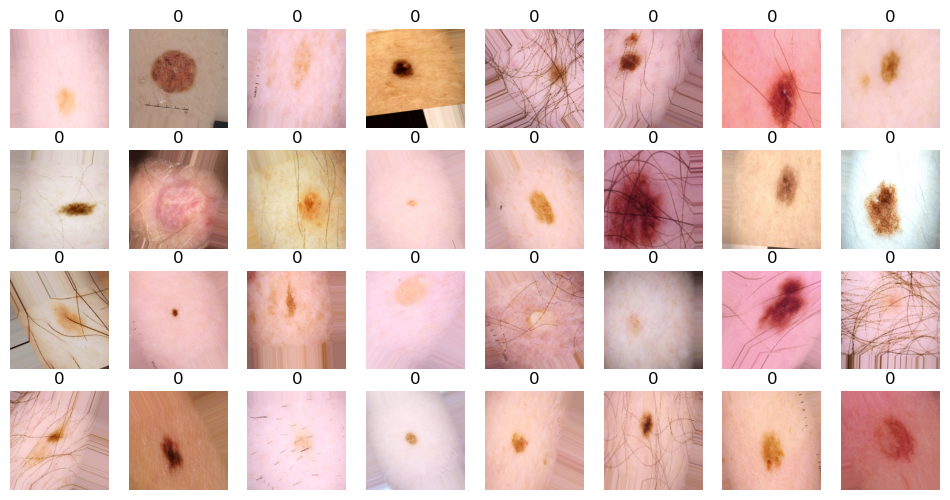

In [21]:
# Prikaz primera slika iz dataset-a
for images, labels in dataset:
    fig, ax = plt.subplots(4, 8, figsize=(12, 6))
    ax = ax.flatten()
    
    for i in range(len(ax)):
        ax[i].imshow(images[i])
        ax[i].set_title(f"{labels[i]}")
        ax[i].axis('off')
    break
plt.show()